In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pyodbc

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
# Create our session (link) from Python to the DB
session = Session(engine)
Measurement = Base.classes.measurement
Station = Base.classes.station
inspector = inspect(engine)

In [9]:
#preview Measurement (first row)
firstmeasurement = session.query(Measurement).first()
firstmeasurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2abbb6038d0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [10]:
#preview Station (first row)
firststation = session.query(Station).first()
firststation.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2abbb613550>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [11]:
#Identify datatype in table Measurement
columns_measurement = inspector.get_columns('Measurement')
for measure in columns_measurement:
    print(measure['name'], measure["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Identify datatype in table Station
columns_station = inspector.get_columns('Station')
for station in columns_station:
    print(station['name'], station["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#Last date in Measurement table
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [14]:
#First date in Measurement table
session.query(Measurement.date).first()

('2010-01-01')

# Exploratory Climate Analysis

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate date 12 months from most recent date (queried above)
last12months = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
#Derive average precipitation per day across all stations, removing NULL values
precipitation_last12months = session.query(Measurement.date, func.avg(Measurement.prcp)).\
filter(Measurement.date >= last12months).\
filter(Measurement.prcp != 'None').\
group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_last12months, columns=['date', 'prcp'])
precipitation_df = precipitation_df.set_index("date")

# Sort the dataframe by date
precipitation_df.sort_values("date").head()

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


In [16]:
precipitation_df.dtypes

prcp    float64
dtype: object

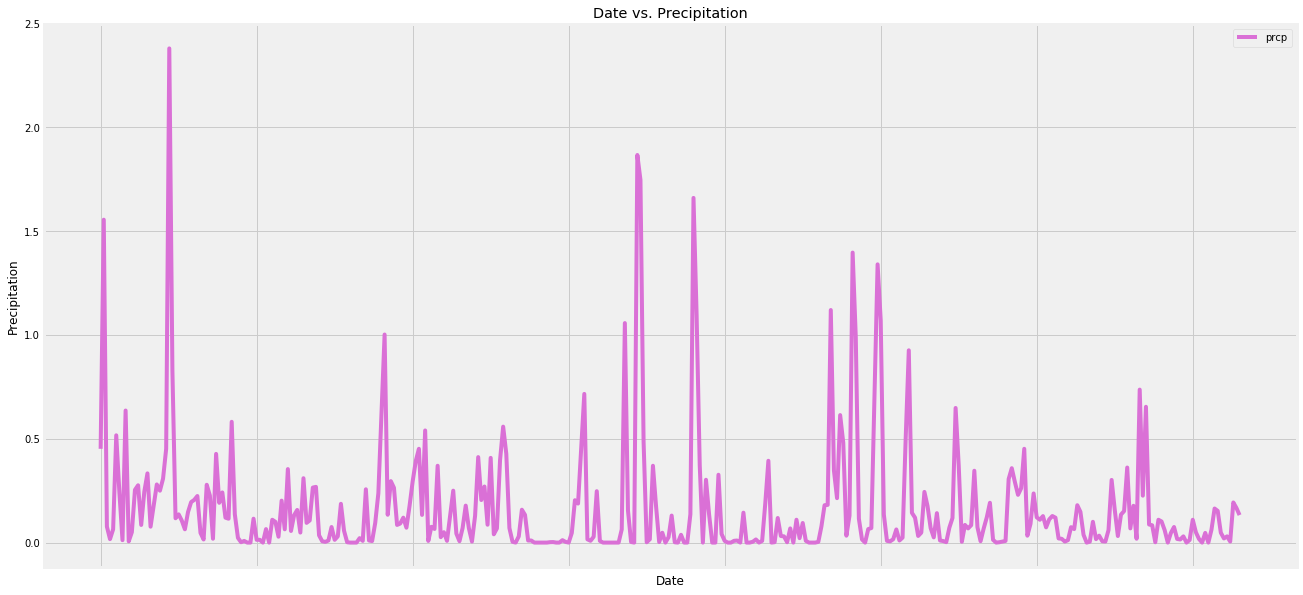

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(kind="line",
               x=None,
               y="prcp", 
               grid=True, 
               figsize=(20,10),
               color="orchid",
               title="Date vs. Precipitation")

plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# NOTE: The expected results showed the data based on all 2022 results - I am showing only the most recent 12 months.
precipitation_df.describe()

,prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [20]:
#Examine data to check for duplicates or data issues...none found.
session.query(Station.name).all()

[('WAIKIKI 717.2, HI US'),
 ('KANEOHE 838.1, HI US'),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('PEARL CITY, HI US'),
 ('UPPER WAHIAWA 874.3, HI US'),
 ('WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('WAIHEE 837.5, HI US'),
 ('HONOLULU OBSERVATORY 702.2, HI US'),
 ('MANOA LYON ARBO 785.2, HI US')]

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.name, Station.id.label("station_id"), func.count(Measurement.id).label("totalbystation")).\
filter(Measurement.station == Station.station).\
group_by(Station.name).\
order_by("totalbystation desc").all()

#For ease of viewing, convert to dataframe
active_stations_df = pd.DataFrame(active_stations)
active_stations_df

C:\Users\Andrew Chin\Anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'totalbystation desc'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


,name,station_id,totalbystation
0,"WAIHEE 837.5, HI US",7,2772
1,"WAIKIKI 717.2, HI US",1,2724
2,"KANEOHE 838.1, HI US",2,2709
3,"WAIMANALO EXPERIMENTAL FARM, HI US",6,2669
4,"MANOA LYON ARBO 785.2, HI US",9,2612
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",3,2202
6,"HONOLULU OBSERVATORY 702.2, HI US",8,1979
7,"PEARL CITY, HI US",4,1372
8,"UPPER WAHIAWA 874.3, HI US",5,511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures = session.query(Station.id.label("station_id"), 
                             func.round(func.min(Measurement.tobs)).label("min_temp"), 
                             func.round(func.max(Measurement.tobs)).label("max_temp"), 
                             func.round(func.avg(Measurement.tobs)).label("avg_temp")).\
filter(Measurement.station == Station.station).\
group_by("station_id").all()

#For ease of viewing, convert to dataframe
temperatures_df = pd.DataFrame(temperatures).set_index("station_id")

combined_temps = temperatures_df.merge(active_stations_df, on="station_id").\
                    sort_values(by="totalbystation", ascending=False).reset_index()
combined_temps = combined_temps.drop(columns=["index"])

combined_temps

,station_id,min_temp,max_temp,avg_temp,name,totalbystation
0,7,54.0,85.0,72.0,"WAIHEE 837.5, HI US",2772
1,1,56.0,87.0,75.0,"WAIKIKI 717.2, HI US",2724
2,2,59.0,85.0,73.0,"KANEOHE 838.1, HI US",2709
3,6,56.0,85.0,75.0,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,9,58.0,84.0,71.0,"MANOA LYON ARBO 785.2, HI US",2612
5,3,58.0,85.0,75.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,8,53.0,87.0,72.0,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,4,58.0,87.0,75.0,"PEARL CITY, HI US",1372
8,5,58.0,83.0,73.0,"UPPER WAHIAWA 874.3, HI US",511


In [23]:
# Choose the station with the highest number of temperature observations.
combined_temps.loc[combined_temps["totalbystation"].idxmax()]

station_id                          7
min_temp                           54
max_temp                           85
avg_temp                           72
name              WAIHEE 837.5, HI US
totalbystation                   2772
Name: 0, dtype: object

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station7data = session.query(Measurement.tobs).\
filter(Measurement.date >= last12months).\
filter(Measurement.station == Station.station).\
filter(Station.id == 7).all()

station7data_df = pd.DataFrame(station7data)
station7data_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


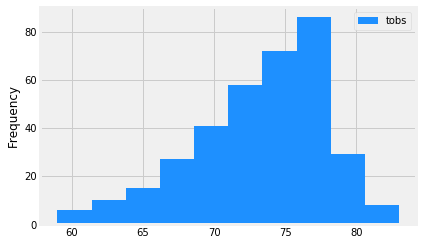

In [25]:
station7data_df.plot(kind='hist', color='dodgerblue')

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):

    return session.query(func.min(Measurement.tobs).label("TMIN"), 
                         func.avg(Measurement.tobs).label("TAVG"), 
                         func.max(Measurement.tobs).label("TMAX")).\
                         filter(Measurement.date >= start_date).\
                         filter(Measurement.date <= end_date).all()

calc_temps('2016-08-23', '2017-08-23')

[(58.0, 74.59058295964125, 87.0)]

In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
currentyear = calc_temps('2016-05-20', '2016-05-25')
prioryear = calc_temps('2017-05-20', '2017-05-25')

# Vacation Current Year (2017): 5/20/2016
# Vacation Prior Year (2016): 5/20/2017
print(f'Current Year: {currentyear}, Prior Year: {prioryear}')

avgtriptemp = currentyear[0].TAVG
avgtriperror = currentyear[0].TMAX-currentyear[0].TMIN
avgtriptemp_df = pd.DataFrame([avgtriptemp])
avgtriptemp_df.columns = ['TAVG']
avgtriptemp_df

Current Year: [(67.0, 75.57894736842105, 79.0)], Prior Year: [(69.0, 75.05714285714286, 87.0)]


,TAVG
0,75.578947


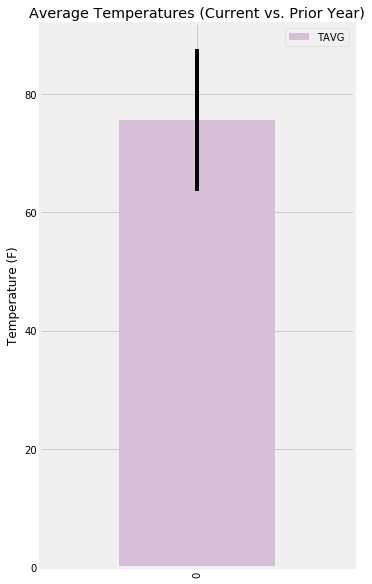

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
#Plot bar chart: average urban and rural reviews by price
# Use Pandas Plotting with Matplotlib to plot the data

error=avgtriperror

avgtriptemp_df.plot(kind="bar",
               grid=True, 
               figsize=(5,10),
               yerr=error,
               color="thistle",
               title="Average Temperatures (Current vs. Prior Year)")

plt.ylabel("Temperature (F)")

plt.show()

In [29]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

SQL = '''SELECT   s.name, s.latitude, s.longitude, s.elevation, AVG(m.prcp) AS [AvgRainfall]
         FROM     Station s INNER JOIN Measurement m
         ON       s.station = m.station
         GROUP BY s.name, s.latitude, s.longitude, s.elevation
         ORDER BY [AvgRainfall] DESC'''

averagerainfall = pd.read_sql_query(SQL, engine)
averagerainfall

,name,latitude,longitude,elevation,AvgRainfall
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.429988
1,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.212352
2,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.207222
3,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141921
4,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.121058
5,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.114961
6,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.063602
7,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.049020
8,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.047971


In [32]:
SQL = '''SELECT     m.date, m.tobs
             FROM       Measurement m INNER JOIN Station s
             ON         m.station = s.station
             WHERE      m.date BETWEEN '2016-08-03' AND '8/23/2017'
             AND        s.id = 7'''
test = pd.read_sql_query(SQL, engine)
test

,date,tobs
0,2016-08-03,77.0
1,2016-08-04,77.0
2,2016-08-05,81.0
3,2016-08-06,78.0
4,2016-08-07,78.0
5,2016-08-08,81.0
6,2016-08-09,81.0
7,2016-08-10,82.0
8,2016-08-11,80.0
9,2016-08-12,76.0
